# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2024**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.15.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit.
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
PROJECT = 'big-data-cw-420712'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = jessguan.city@gmail.com
project = big-data-cw-420712
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://big-data-cw-420712-storage/...
ServiceException: 409 A Cloud Storage bucket named 'big-data-cw-420712-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.5.0


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

In [ ]:
display_9_images_from_dataset(dsetResized)

Output hidden; open in https://colab.research.google.com to view.

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['dandelion', 'roses', 'daisy', 'daisy', 'daisy', 'sunflowers', 'sunflowers', 'daisy', 'dandelion', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['roses', 'dandelion', 'dandelion', 'roses', 'daisy', 'dandelion', 'roses', 'dandelion', 'daisy', 'roses'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'dandelion', 'dandelion', 'daisy', 'roses', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'daisy'])
Image batch shape (10, 192, 192, 3), ['tulips', 'roses', 'dandelion', 'roses', 'sunflowers', 'daisy', 'daisy', 'daisy', 'daisy', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'daisy', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['roses', 'daisy', 'sunflowers', 'roses', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'tulips', 'roses'])
Image batch shape (10, 192, 192, 3), ['roses', 'roses', 'dandelion', 'daisy', 'sunflowers', 'dandelio

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [ ]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['daisy', 'roses', 'dandelion', 'tulips', 'tulips', 'tulips', 'roses', 'tulips', 'roses', 'tulips'])
Image batch shape (10,), ['tulips', 'dandelion', 'dandelion', 'tulips', 'roses', 'dandelion', 'daisy', 'daisy', 'tulips', 'dandelion'])
Image batch shape (10,), ['dandelion', 'sunflowers', 'tulips', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'sunflowers', 'dandelion', 'roses'])
Image batch shape (10,), ['tulips', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'roses', 'dandelion', 'daisy', 'dandelion', 'tulips'])
Image batch shape (10,), ['sunflowers', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'roses', 'roses', 'daisy', 'dandelion'])
Image batch shape (10,), ['daisy', 'sunflowers', 'sunflowers', 'roses', 'tulips', 'sunflowers', 'daisy', 'roses', 'roses', 'dandelion'])
Image batch shape (10,), ['daisy', 'daisy', 'dandelion', 'tulips', 'dandelion', 'daisy', 'roses', 'tulips', 'sunflowers', 'tulips'])
Image batch shape (10,), ['dande

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

#  write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'])
Image batch shape (10, 192, 192, 3), ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2'])
Image batch shape (10, 192, 192, 3), ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2'])
Image batch shape (10, 192, 192, 3), ['3', '3', '3', '3', '3', '3', '3', '3', '3', '3'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


i) Copy over the mapping functions (see section 1.1) and adapt the resizing and recompression functions to Spark (only one argument).

In [ ]:
# i) Copy over the mapping functions (see section 1.1) and adapt the resizing and
# recompression functions to Spark (only one argument).

# copy and paste mapping functions
def decode_jpeg_and_label_spark(filepath):
    bits = tf.io.read_file(filepath) # read file from the filepath
    image = tf.image.decode_jpeg(bits) # decodes jpeg image into uint8 tensor
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2] # extracts label
    return (image, label) # returns tuple of image tensor and label

# adapted resize and crop function to spark
# params:
# image_label : list of image and label file urls
def resize_and_crop_image_spark(image_label):
    image, label = image_label # unpacks the tuple
    TARGET_SIZE = [192, 192] # target size
    w = tf.shape(image)[0] # get height of image
    h = tf.shape(image)[1] # get width of image
    tw = TARGET_SIZE[1] # target width
    th = TARGET_SIZE[0] # target height
    resize_crit = (w * th) / (h * tw) # resize criterion
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true, resize to keep width and change heigt
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])) # if false, resize to keep height and change width
    # get resized image dimensions
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th) # crop to target size
    return (image, label) # return tuple of resized and cropped image and label

# adapted recompress function to spark
# params:
# image_label : list of image and label file urls
def recompress_image_spark(image_label):
    image, label = image_label # unpack the tuple
    image = tf.cast(image, tf.uint8) # cast iamge to uint8 tensor
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False) # recompress image
    return (image, label) # returns tuple of recompressed image and label

ii) Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames
 <br> iii) Sample the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests.

In [ ]:
# ii) Replace the TensorFlow Dataset objects with RDDs, starting with an
# RDD that contains the list of image filenames

file_paths = tf.io.gfile.glob(GCS_PATTERN) # get list of files
files_rdd = sc.parallelize(file_paths) # create RDD

## iii) Sample the the RDD to a smaller number at an appropriate position in the code.
# Specify a sampling factor of 0.02 for short tests.

sampled_rdd = files_rdd.sample(False, 0.02) # sample by 0.02


In [ ]:
# check RDD creation
print("Total files loaded:", files_rdd.count())

Total files loaded: 3670


In [ ]:
# apply the functions to the RDD and check output to ensure that it is processing all images correctly

decoded_images = files_rdd.map(decode_jpeg_and_label_spark)
print("Decoded images:", decoded_images.filter(lambda x: x[0] is not None).count())

resized_images = decoded_images.map(resize_and_crop_image_spark)
print("Resized images:", resized_images.filter(lambda x: x[0] is not None).count())

recompressed_images = resized_images.map(recompress_image_spark)
print("Recompressed images:", recompressed_images.filter(lambda x: x[0] is not None).count())


Decoded images: 3670
Resized images: 3670
Recompressed images: 3670


iv) Then use the functions from above to write the TFRecord files.
<br> v) The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function. The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files

In [ ]:
# iv) Then use the functions from above to write the TFRecord files.
# v) The code for writing to the TFRecord files needs to be put into a function, that
# can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function.
# The return value of that function is not used here, but you should return the filename,
# so that you have a list of the created TFRecord files

def write_partition_to_tfrecord(index, iterator):
    # create output path for the output TFRecord file where each partition is a unique file
    output_path = f'{GCS_OUTPUT}partition_{index:04d}.tfrec'
    # create writer object to write to the TFRecord files
    writer = tf.io.TFRecordWriter(output_path)
    # counter to keep track of the number of records written
    count = 0

    # iterate through the data in current partition
    for image_bytes, label in iterator:
        # convert label to a class number based on the CLASSES array defined earlier
        class_num = np.argmax(np.array(CLASSES) == label.numpy())
        # create a tensorflow example object
        example = tf.train.Example(features=tf.train.Features(feature={
            "image": _bytestring_feature([image_bytes.numpy()]), # serialize image bytes
            "class": _int_feature([class_num]), # serialize class number
        }))
        # write to TFRecord
        writer.write(example.SerializeToString())
        count += 1 # add to count

    writer.close() # close writer object
    return [(output_path, count)] # return output path and the number of records written for each partition.

def write_tfrecords(rdd, num_partitions):
    # repartition RDD
    partitioned_rdd = rdd.repartition(num_partitions)
    # apply write_partition_to_tfrecord function to partitions of the RDD and collect results
    results = partitioned_rdd.mapPartitionsWithIndex(write_partition_to_tfrecord).collect()

    # print results
    for result in results:
        print(f"Written {result[1]} records to {result[0]}")

num_partitions = 16  # number of partitions
write_tfrecords(recompressed_images, num_partitions) # apply write_tfrecords

Written 228 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0000.tfrec
Written 220 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0001.tfrec
Written 220 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0002.tfrec
Written 220 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0003.tfrec
Written 240 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0004.tfrec
Written 240 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0005.tfrec
Written 232 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0006.tfrec
Written 230 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0007.tfrec
Written 230 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0008.tfrec
Written 230 records to gs://

### 1b) Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.

In [ ]:
# load dataset from the storage bucket that the TFRecords were written to
tfrecord_files = tf.io.gfile.glob('gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/*.tfrec')
dataset = load_dataset(tfrecord_files)

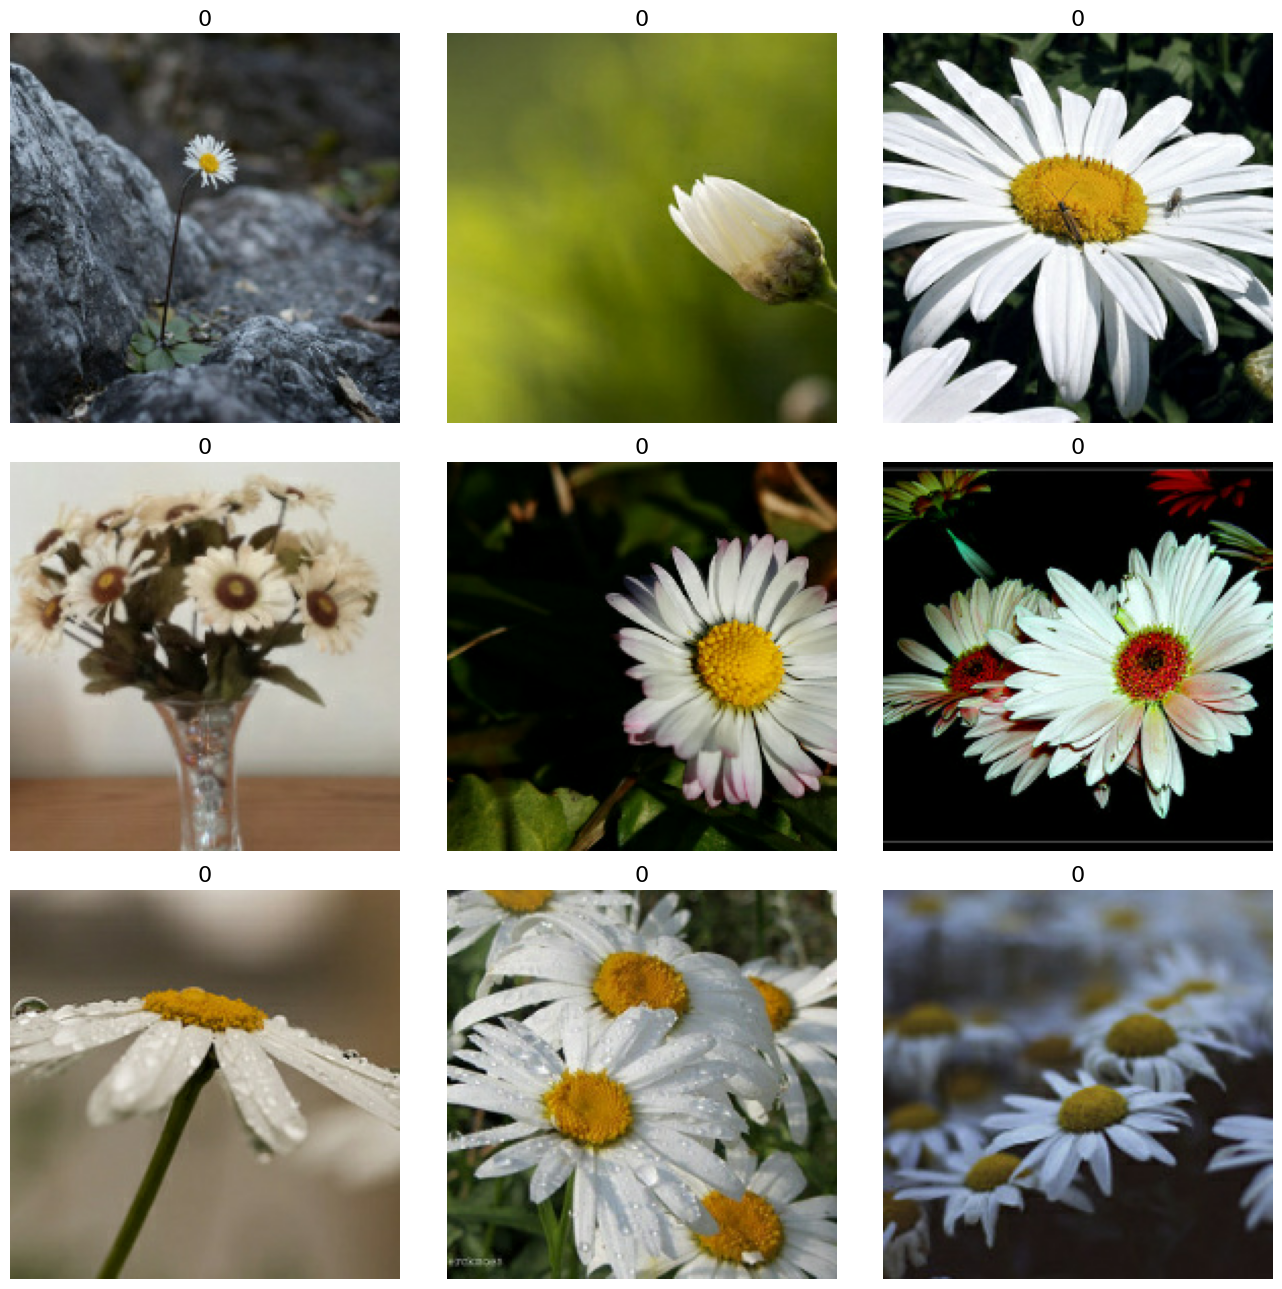

In [ ]:
display_9_images_from_dataset(dataset)


ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [ ]:
%%writefile spark_write_tfrec.py
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PROJECT = 'big-data-cw-420712'  ### USE YOUR PROJECT ID HERE. ###
BUCKET = 'gs://{}-storage'.format(PROJECT)
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
#import findspark
os.environ["SPARK_HOME"] = "/usr/lib/spark"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

#import os
#os.environ["SPARK_HOME"] = "/usr/lib/spark"
#import findspark
#findspark.init()
# ------------------------------------------
# functions given
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# -----------------------------------------------------------
# functions written for spark

# i) Copy over the mapping functions (see section 1.1) and adapt the resizing and
# recompression functions to Spark (only one argument).

# copy and paste mapping functions
def decode_jpeg_and_label_spark(filepath):
    bits = tf.io.read_file(filepath) # read file from the filepath
    image = tf.image.decode_jpeg(bits) # decodes jpeg image into uint8 tensor
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2] # extracts label
    return (image, label) # returns tuple of image tensor and label

# adapted resize and crop function to spark
# params:
# image_label : a tuple of image tensor and label
def resize_and_crop_image_spark(image_label):
    image, label = image_label # unpacks the tuple
    TARGET_SIZE = [192, 192] # target size
    w = tf.shape(image)[0] # get height of image
    h = tf.shape(image)[1] # get width of image
    tw = TARGET_SIZE[1] # target width
    th = TARGET_SIZE[0] # target height
    resize_crit = (w * th) / (h * tw) # resize criterion
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true, resize to keep width and change heigt
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])) # if false, resize to keep height and change width
    # get resized image dimensions
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th) # crop to target size
    return (image, label) # return tuple of resized and cropped image and label

# adapted recompress function to spark
# params:
# image_label : a tuple of image tensor and label
def recompress_image_spark(image_label):
    image, label = image_label # unpack the tuple
    image = tf.cast(image, tf.uint8) # cast iamge to uint8 tensor
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False) # recompress image
    return (image, label) # returns tuple of recompressed image and label

# ii) Replace the TensorFlow Dataset objects with RDDs, starting with an
# RDD that contains the list of image filenames
file_paths = tf.io.gfile.glob(GCS_PATTERN) # get list of files
files_rdd = sc.parallelize(file_paths,1) # create RDD

## iii) Sample the the RDD to a smaller number at an appropriate position in the code.
# Specify a sampling factor of 0.02 for short tests.
sampled_rdd = files_rdd.sample(False, 0.02) # sample by 0.02

# apply functions to images
decoded_images = files_rdd.map(decode_jpeg_and_label_spark)
resized_images = decoded_images.map(resize_and_crop_image_spark)
recompressed_images = resized_images.map(recompress_image_spark)

def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

# iv) Then use the functions from above to write the TFRecord files.
# v) The code for writing to the TFRecord files needs to be put into a function, that
# can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function.
# The return value of that function is not used here, but you should return the filename,
# so that you have a list of the created TFRecord files

def write_partition_to_tfrecord(index, iterator):
    # create output path for the output TFRecord file where each partition is a unique file
    output_path = f'{GCS_OUTPUT}partition_{index:04d}.tfrec'
    # create writer object to write to the TFRecord files
    writer = tf.io.TFRecordWriter(output_path)
    # counter to keep track of the number of records written
    count = 0

    # iterate through the data in current partition
    for image_bytes, label in iterator:
        # convert label to a class number based on the CLASSES array defined earlier
        class_num = np.argmax(np.array(CLASSES) == label.numpy())
        # create a tensorflow example object
        example = tf.train.Example(features=tf.train.Features(feature={
            "image": _bytestring_feature([image_bytes.numpy()]), # serialize image bytes
            "class": _int_feature([class_num]), # serialize class number
        }))
        # write to TFRecord
        writer.write(example.SerializeToString())
        count += 1 # add to count

    writer.close() # close writer object
    return [(output_path, count)] # return output path and the number of records written for each partition.

def write_tfrecords(rdd, num_partitions):
    start_time = time.time() # start timer

    # repartition RDD
    partitioned_rdd = rdd.repartition(num_partitions)
    # apply write_partition_to_tfrecord function to partitions of the RDD and collect results
    results = partitioned_rdd.mapPartitionsWithIndex(write_partition_to_tfrecord).collect()
    end_time = time.time()  # end timer
    # print time
    print("Time taken to process and write TFRecords: {:.2f} seconds".format(end_time - start_time))

    # print results
    for result in results:
        print(f"Written {result[1]} records to {result[0]}")

num_partitions = 16  #  number of partitions
write_tfrecords(recompressed_images, num_partitions) # apply write_tfrecords

# testing
tfrecord_files = tf.io.gfile.glob('gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/*.tfrec')
dataset = load_dataset(tfrecord_files)

display_9_images_from_dataset(dataset)

Overwriting spark_write_tfrec.py


Tensorflow version 2.15.0
3.5.0
<SparkContext master=local[*] appName=pyspark-shell>
Written 228 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0000.tfrec
Written 220 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0001.tfrec
Written 220 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0002.tfrec
Written 220 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0003.tfrec
Written 240 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0004.tfrec
Written 240 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0005.tfrec
Written 232 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0006.tfrec
Written 230 records to gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowerspartition_0007.tfrec
Written 230 records to gs://big-data-cw-420712-stor

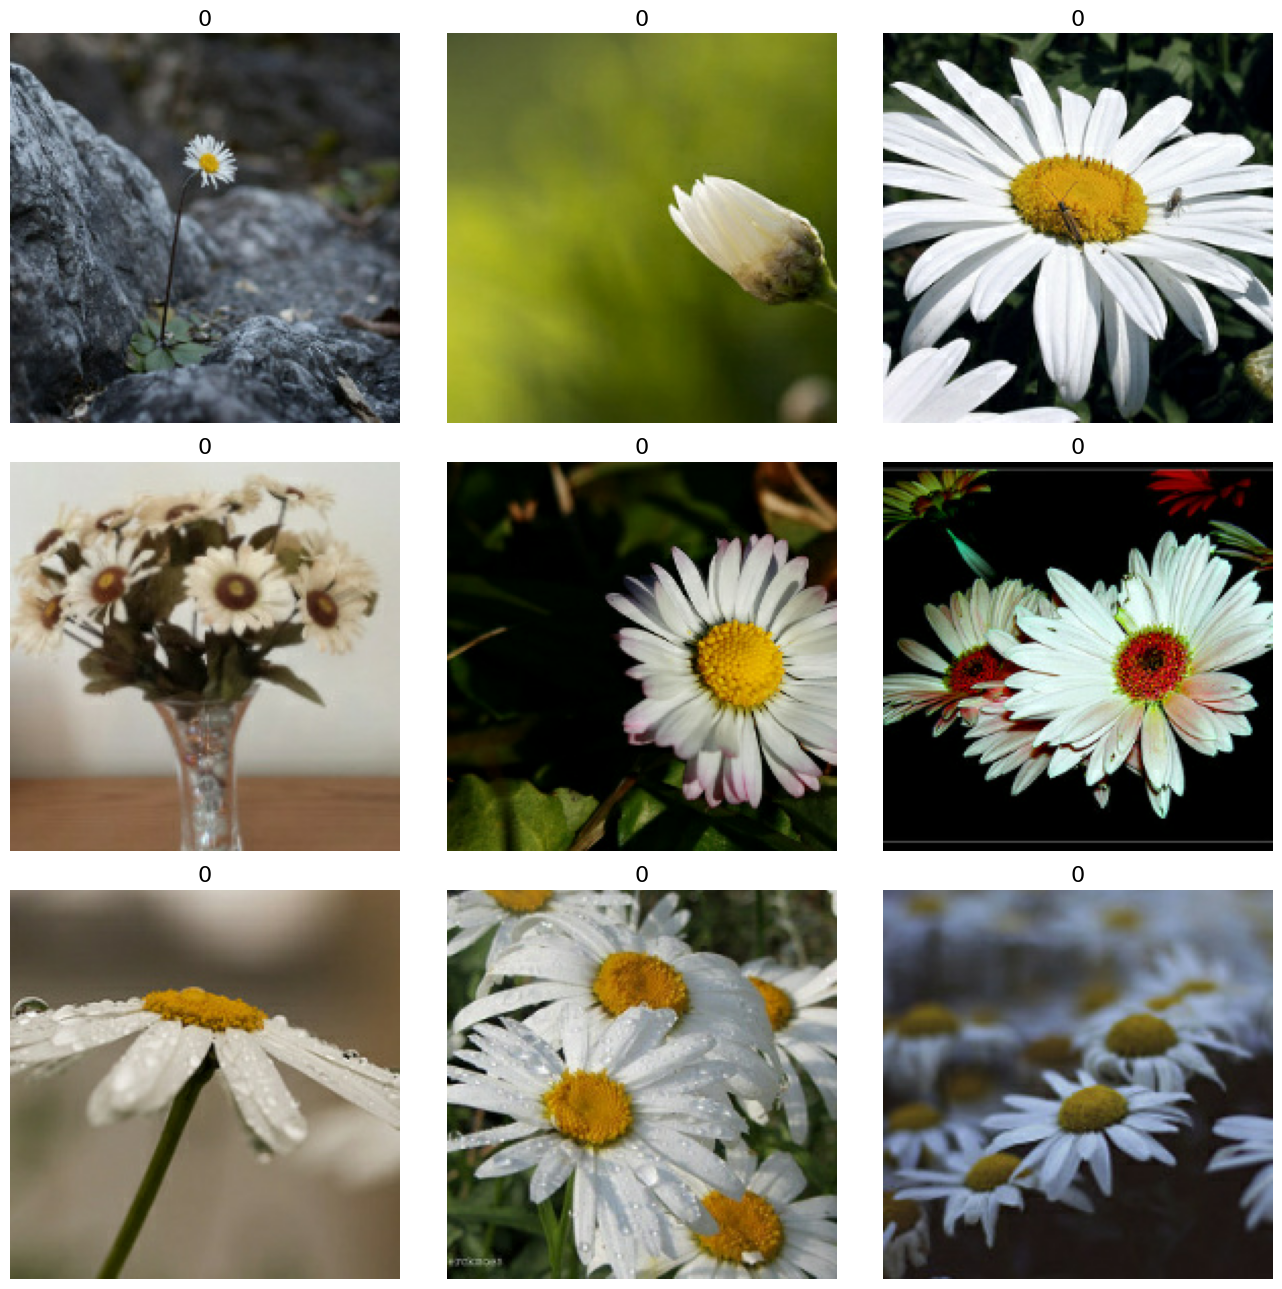

<Figure size 640x480 with 0 Axes>

In [ ]:
# test script locally
%run spark_write_tfrec.py

### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
!gcloud services enable cloudresourcemanager.googleapis.com


Operation "operations/acat.p2-168558794870-87bd3a9d-b79b-4641-b9c7-a7cda3915ae7" finished successfully.


In [ ]:
# set global variables for region, zone, bucket name, tensforflow version
region = 'us-central1'  # region
zone = region + '-c'  # zone
tensorflow_version = 'tensorflow==2.4.0'
bucket_name = 'big-data-cw-420712-storage'

In [ ]:
# create cluster
!gcloud dataproc clusters create 'bd-cluster' \
    --region={region} \
    --zone={zone} \
    --single-node \
    --master-machine-type='n1-standard-8' \
    --master-boot-disk-size=100 \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata='PIP_PACKAGES=protobuf==3.20.* scipy tensorflow==2.4.0 numpy matplotlib findspark'




Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/1658755e-d60f-3130-bd0a-0ca83573f7da].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/bd-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
# check cluster is running
!gcloud dataproc clusters list --region={region}


NAME        PLATFORM  PRIMARY_WORKER_COUNT  SECONDARY_WORKER_COUNT  STATUS   ZONE           SCHEDULED_DELETE
bd-cluster  GCE                                                     RUNNING  us-central1-c


Run the script in the cloud and test the output.

In [ ]:
# deploy script to the cluster
!gcloud dataproc jobs submit pyspark --cluster 'bd-cluster' --region 'us-central1'\
    ./spark_write_tfrec.py


Job [bff2d1905e9b4ce0a91f2efcb0d34cfd] submitted.
Waiting for job output...
2024-04-29 15:27:02.146110: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-29 15:27:02.146161: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
24/04/29 15:27:10 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/29 15:27:10 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/29 15:27:11 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/29 15:27:11 INFO org.spark_project.jetty.util.log: Logging initialized @16640ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/29 15:27:11 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT

In [ ]:
# DELETE CLUSTER WHEN NOT IN USE TO PREVENT BILLING
cluster_name = 'bd-cluster'
!gcloud dataproc clusters delete {cluster_name} --region={region} --quiet

Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/22b4104b-f6f8-3942-9895-460c70647248].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/bd-cluster].


In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [ ]:
# create max cluster
!gcloud dataproc clusters create 'max-cluster' \
    --region={region} \
    --zone={zone} \
    --master-machine-type=n1-standard-1 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=100 \
    --num-workers=7 \
    --worker-machine-type=n1-standard-1 \
    --worker-boot-disk-type=pd-ssd \
    --worker-boot-disk-size=100 \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata='PIP_PACKAGES=protobuf==3.20.* scipy tensorflow==2.4.0 numpy matplotlib findspark'

ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Multiple validation errors:
 - Insufficient 'IN_USE_ADDRESSES' quota. Requested 8.0, available 4.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
 - Insufficient 'SSD_TOTAL_GB' quota. Requested 800.0, available 250.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.


The quota given on my account will not allow me to create a cluster with 1 master and 7 worker nodes, and I also have limited SSD_TOTAL_GB. Because of this my maximumal cluster will have 1 master and 3 worker nodes, and smaller SSD_TOTAL_GB.

In [ ]:
# create max cluster with available resources and quotas
!gcloud dataproc clusters create 'max-cluster' \
    --region={region} \
    --zone={zone} \
    --master-machine-type=n1-standard-1 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=62 \
    --num-workers=3 \
    --worker-machine-type=n1-standard-1 \
    --worker-boot-disk-type=pd-ssd \
    --worker-boot-disk-size=62 \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata='PIP_PACKAGES=protobuf==3.20.* scipy tensorflow==2.4.0 numpy matplotlib findspark'


Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/410ac8c7-6c22-3ddb-9aee-322e4a7742b5].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/max-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
# check cluster is running
gcloud dataproc clusters list --region={region}


NAME         PLATFORM  PRIMARY_WORKER_COUNT  SECONDARY_WORKER_COUNT  STATUS   ZONE           SCHEDULED_DELETE
max-cluster  GCE       3                                             RUNNING  us-central1-c


In [ ]:
# deploy script to cluster
!gcloud dataproc jobs submit pyspark --cluster 'max-cluster' --region 'us-central1'\
    ./spark_write_tfrec.py


Job [49c5b3e38be344e1b047327b655d1f78] submitted.
Waiting for job output...
2024-04-29 14:56:42.374022: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-29 14:56:42.374207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
24/04/29 14:56:46 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/29 14:56:47 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/29 14:56:47 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/29 14:56:47 INFO org.spark_project.jetty.util.log: Logging initialized @15086ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/29 14:56:47 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT

In [ ]:
# DELETE CLUSTER WHEN NOT IN USE TO PREVENT BILLING
cluster_name = 'max-cluster'  # replace with the name of your cluster
!gcloud dataproc clusters delete {cluster_name} --region={region} --quiet

Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/c5074d00-6850-3227-8f4e-e696ef5598eb].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/max-cluster].


### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


In [ ]:
# i) Improve parallelisation

%%writefile spark_write_tfrec.py
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PROJECT = 'big-data-cw-420712'  ### USE YOUR PROJECT ID HERE. ###
BUCKET = 'gs://{}-storage'.format(PROJECT)
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
#import findspark
os.environ["SPARK_HOME"] = "/usr/lib/spark"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

#import os
#os.environ["SPARK_HOME"] = "/usr/lib/spark"
#import findspark
#findspark.init()
# ------------------------------------------
# functions given
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

# -----------------------------------------------------------
# functions written for spark

# i) Copy over the mapping functions (see section 1.1) and adapt the resizing and
# recompression functions to Spark (only one argument).

# copy and paste mapping functions
def decode_jpeg_and_label_spark(filepath):
    bits = tf.io.read_file(filepath) # read file from the filepath
    image = tf.image.decode_jpeg(bits) # decodes jpeg image into uint8 tensor
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/').values[-2] # extracts label
    return (image, label) # returns tuple of image tensor and label

# adapted resize and crop function to spark
# params:
# image_label : a tuple of image tensor and label
def resize_and_crop_image_spark(image_label):
    image, label = image_label # unpacks the tuple
    TARGET_SIZE = [192, 192] # target size
    w = tf.shape(image)[0] # get height of image
    h = tf.shape(image)[1] # get width of image
    tw = TARGET_SIZE[1] # target width
    th = TARGET_SIZE[0] # target height
    resize_crit = (w * th) / (h * tw) # resize criterion
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true, resize to keep width and change heigt
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])) # if false, resize to keep height and change width
    # get resized image dimensions
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th) # crop to target size
    return (image, label) # return tuple of resized and cropped image and label

# adapted recompress function to spark
# params:
# image_label : a tuple of image tensor and label
def recompress_image_spark(image_label):
    image, label = image_label # unpack the tuple
    image = tf.cast(image, tf.uint8) # cast iamge to uint8 tensor
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False) # recompress image
    return (image, label) # returns tuple of recompressed image and label

# ii) Replace the TensorFlow Dataset objects with RDDs, starting with an
# RDD that contains the list of image filenames
file_paths = tf.io.gfile.glob(GCS_PATTERN) # get list of files
PARTITIONS = 16
files_rdd = sc.parallelize(file_paths, PARTITIONS) # create RDD with 16 partitions


## iii) Sample the the RDD to a smaller number at an appropriate position in the code.
# Specify a sampling factor of 0.02 for short tests.
sampled_rdd = files_rdd.sample(False, 0.02) # sample by 0.02

# apply functions to images
decoded_images = files_rdd.map(decode_jpeg_and_label_spark)
resized_images = decoded_images.map(resize_and_crop_image_spark)
recompressed_images = resized_images.map(recompress_image_spark)

def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

# iv) Then use the functions from above to write the TFRecord files.
# v) The code for writing to the TFRecord files needs to be put into a function, that
# can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function.
# The return value of that function is not used here, but you should return the filename,
# so that you have a list of the created TFRecord files

def write_partition_to_tfrecord(index, iterator):
    # create output path for the output TFRecord file where each partition is a unique file
    output_path = f'{GCS_OUTPUT}partition_{index:04d}.tfrec'
    # create writer object to write to the TFRecord files
    writer = tf.io.TFRecordWriter(output_path)
    # counter to keep track of the number of records written
    count = 0

    # iterate through the data in current partition
    for image_bytes, label in iterator:
        # convert label to a class number based on the CLASSES array defined earlier
        class_num = np.argmax(np.array(CLASSES) == label.numpy())
        # create a tensorflow example object
        example = tf.train.Example(features=tf.train.Features(feature={
            "image": _bytestring_feature([image_bytes.numpy()]), # serialize image bytes
            "class": _int_feature([class_num]), # serialize class number
        }))
        # write to TFRecord
        writer.write(example.SerializeToString())
        count += 1 # add to count

    writer.close() # close writer object
    return [(output_path, count)] # return output path and the number of records written for each partition.

def write_tfrecords(rdd, num_partitions):
    start_time = time.time() # start timer

    # repartition RDD
    partitioned_rdd = rdd.repartition(num_partitions)
    # apply write_partition_to_tfrecord function to partitions of the RDD and collect results
    results = partitioned_rdd.mapPartitionsWithIndex(write_partition_to_tfrecord).collect()
    end_time = time.time()  # end timer
    # print time
    print("Time taken to process and write TFRecords: {:.2f} seconds".format(end_time - start_time))

    # print results
    for result in results:
        print(f"Written {result[1]} records to {result[0]}")

num_partitions = 16  #  number of partitions
write_tfrecords(recompressed_images, num_partitions) # apply write_tfrecords

# testing
tfrecord_files = tf.io.gfile.glob('gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/*.tfrec')
dataset = load_dataset(tfrecord_files)

display_9_images_from_dataset(dataset)

Overwriting spark_write_tfrec.py


ii) Experiment with cluster configurations.

#### Cluster 4 VMs

In [ ]:
!gcloud dataproc clusters create 'max-cluster' \
    --region={region} \
    --zone={zone} \
    --master-machine-type=n1-standard-1 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=62 \
    --num-workers=3 \
    --worker-machine-type=n1-standard-1 \
    --worker-boot-disk-type=pd-ssd \
    --worker-boot-disk-size=62 \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata='PIP_PACKAGES=protobuf==3.20.* scipy tensorflow==2.4.0 numpy matplotlib findspark'


Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/410ac8c7-6c22-3ddb-9aee-322e4a7742b5].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/max-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster 'max-cluster' --region 'us-central1'\
    ./spark_write_tfrec.py

Job [d7ac4f7b264349e3a5a978bf3fbf241c] submitted.
Waiting for job output...
2024-04-29 15:12:01.570089: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-29 15:12:01.570275: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
24/04/29 15:12:05 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/29 15:12:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/29 15:12:05 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/29 15:12:06 INFO org.spark_project.jetty.util.log: Logging initialized @10177ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/29 15:12:06 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT

In [ ]:
# DELETE CLUSTER WHEN NOT IN USE TO PREVENT BILLING
cluster_name = 'vm4-cluster'  # replace with the name of your cluster
!gcloud dataproc clusters delete {cluster_name} --region={region} --quiet

ERROR: (gcloud.dataproc.clusters.delete) NOT_FOUND: Not found: Cluster projects/big-data-cw-420712/regions/us-central1/clusters/vm4-cluster


#### Cluster 3 VMs

In [ ]:
!gcloud dataproc clusters create 'vm3-cluster' \
    --region={region} \
    --zone={zone} \
    --master-machine-type=n1-standard-2 \
    --master-boot-disk-type=pd-ssd \
    --master-boot-disk-size=62 \
    --num-workers=2 \
    --worker-machine-type=n1-standard-2 \
    --worker-boot-disk-type=pd-ssd \
    --worker-boot-disk-size=62 \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata='PIP_PACKAGES=protobuf==3.20.* scipy tensorflow==2.4.0 numpy matplotlib findspark'


Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/2fbcb506-b362-36cd-9101-4621d2255899].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/vm3-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
!gcloud dataproc clusters list --region={region}


NAME         PLATFORM  PRIMARY_WORKER_COUNT  SECONDARY_WORKER_COUNT  STATUS   ZONE           SCHEDULED_DELETE
vm3-cluster  GCE       2                                             RUNNING  us-central1-c


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster 'vm3-cluster' --region 'us-central1'\
    ./spark_write_tfrec.py

Job [fdd665d03a014c85bf3114ac99f0f080] submitted.
Waiting for job output...
2024-04-29 19:02:53.062712: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-29 19:02:53.062752: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
24/04/29 19:02:56 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/29 19:02:56 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/29 19:02:56 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/29 19:02:57 INFO org.spark_project.jetty.util.log: Logging initialized @11940ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/29 19:02:57 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT

In [ ]:
# DELETE CLUSTER WHEN NOT IN USE TO PREVENT BILLING
cluster_name = 'vm3-cluster'  # replace with the name of your cluster
!gcloud dataproc clusters delete {cluster_name} --region={region} --quiet

Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/ec91e759-414f-3e10-a605-845181a0a676].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/vm3-cluster].


#### Cluster 1 VM

In [ ]:
region = 'us-central1'  # Choose an appropriate region close to your data or users
zone = region + '-c'  # Adjust the zone if necessary
cluster_name = 'bd-cluster'
machine_type = 'n1-standard-8'  # 8 vCPUs
disk_size = 100  # 100 GB SSD
tensorflow_version = 'tensorflow==2.4.0'  # Specify TensorFlow version
bucket_name = 'big-data-cw-420712-storage'

# Create the cluster
!gcloud dataproc clusters create {cluster_name} \
    --region={region} \
    --zone={zone} \
    --single-node \
    --master-machine-type={machine_type} \
    --master-boot-disk-size={disk_size} \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata='PIP_PACKAGES=protobuf==3.20.* scipy tensorflow==2.4.0 numpy matplotlib findspark'




Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/36c98fa0-7913-3bea-a455-58a4b70c4b79].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/bd-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
!gcloud dataproc clusters list --region={region}


NAME        PLATFORM  PRIMARY_WORKER_COUNT  SECONDARY_WORKER_COUNT  STATUS   ZONE           SCHEDULED_DELETE
bd-cluster  GCE                                                     RUNNING  us-central1-c


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster 'bd-cluster' --region 'us-central1'\
    ./spark_write_tfrec.py

Job [0fb2333493434e44b5c2973de7b59399] submitted.
Waiting for job output...
2024-04-29 18:29:32.313148: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-29 18:29:32.313186: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
24/04/29 18:29:35 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/29 18:29:35 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/29 18:29:35 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/29 18:29:35 INFO org.spark_project.jetty.util.log: Logging initialized @9571ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/29 18:29:35 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT;

In [ ]:
# DELETE CLUSTER WHEN NOT IN USE TO PREVENT BILLING
cluster_name = 'bd-cluster'  # replace with the name of your cluster
!gcloud dataproc clusters delete {cluster_name} --region={region} --quiet

Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/15e214f7-c97f-3a12-bb80-38844cb9d838].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/bd-cluster].


# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print("dimensions:",dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print("results shape:", results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params



**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [ ]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print('-----')
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

dimensions: [2, 2, 1]
results shape: (2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'daisy'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'tulips'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'sunflowers'"]) <_io.TextIOW

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)

In [ ]:
# copy and pasted the given functions from previous sections

def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset



In [ ]:
# parameter values to test
batch_sizes = [4, 8, 16]
batch_numbers = [6, 12, 24]
repetitions = [1, 2, 3]

# create all combinations of parameters for testing
parameter_combinations = [(bs, bn, rep) for bs in batch_sizes for bn in batch_numbers for rep in repetitions]
# create RDD
parameters_rdd = sc.parallelize(parameter_combinations)

ii) get a Spark context and create the dataset and run timing test for each combination in parallel (2%)

In [ ]:
def time_test(parameters, dataset_type):
    import time
    import tensorflow as tf  # import tf on each spark node

    bs, bn, rep = parameters # unpack parameters
    start = time.time() # start timer

    # determine the dataset based on the type passed
    if dataset_type == 'GCS': # for image files
        filenames = tf.data.Dataset.list_files(GCS_PATTERN) # get list of image files
        # apply processing functions to the image files
        dataset1 = filenames.map(decode_jpeg_and_label)
        dataset2 = dataset1.map(resize_and_crop_image)
        dataset = dataset2.map(recompress_image)
    elif dataset_type == 'TFREC': # for TFRecord files
        filenames = tf.data.Dataset.list_files(GCS_OUTPUT + "*.tfrec") # get list of files
        dataset = load_dataset(filenames) # load dataset

    # dataset batched according to bs and limited to bn batches.
    dataset = dataset.batch(bs).take(bn)

    # simulate processing and print output to /dev/null
    processed_batches = 0
    with open("/dev/null", "w") as f_null:
        for _ in range(rep):
            for batch in dataset:
                processed_batches += 1
                print("Processing batch...", file=f_null)

    end = time.time() # end timer
    total_images = bs * bn * rep # calculate total number of images processed
    # calculates throughput in images per second
    images_per_second = total_images / (end - start) if end - start > 0 else 0

    return (parameters, images_per_second) # return the parameters and images per second throughput

In [ ]:
# apply time test function using spark
results_rdd_gcs = parameters_rdd.map(lambda params: time_test(params, 'GCS')) # image files
results_rdd_tfrec = parameters_rdd.map(lambda params: time_test(params, 'TFREC')) #TFRecords files

# collect results
collected_results_tfrec = results_rdd_tfrec.collect() #TFRecords files
collected_results_gcs = results_rdd_gcs.collect() # image files


# print results
for result in collected_results_gcs:
    print(f"GCS - Parameters: {result[0]}, Images per second: {result[1]}")
for result in collected_results_tfrec:
    print(f"TFREC - Parameters: {result[0]}, Images per second: {result[1]}")


GCS - Parameters: (4, 6, 1), Images per second: 14.703981557668293
GCS - Parameters: (4, 6, 2), Images per second: 10.817516904503291
GCS - Parameters: (4, 6, 3), Images per second: 12.288639533283002
GCS - Parameters: (4, 12, 1), Images per second: 12.551520646862198
GCS - Parameters: (4, 12, 2), Images per second: 14.988625225427848
GCS - Parameters: (4, 12, 3), Images per second: 17.447692536173182
GCS - Parameters: (4, 24, 1), Images per second: 23.61864897117005
GCS - Parameters: (4, 24, 2), Images per second: 20.9707701857431
GCS - Parameters: (4, 24, 3), Images per second: 18.83180899441367
GCS - Parameters: (8, 6, 1), Images per second: 11.934880793817873
GCS - Parameters: (8, 6, 2), Images per second: 16.474836170475584
GCS - Parameters: (8, 6, 3), Images per second: 22.62738496033987
GCS - Parameters: (8, 12, 1), Images per second: 17.2610311971006
GCS - Parameters: (8, 12, 2), Images per second: 17.98711839461916
GCS - Parameters: (8, 12, 3), Images per second: 18.8579598070

In [ ]:
# save as pkl files in drive as backups
with open('/content/drive/MyDrive/BD-CW/collected_results_gcs2.pkl', 'wb') as f:
    pickle.dump(collected_results_gcs, f)

with open('/content/drive/MyDrive/BD-CW/collected_results_tfrec2.pkl', 'wb') as f:
    pickle.dump(collected_results_tfrec, f)

iii) transform the resulting RDD to the structure ( parameter_combination, images_per_second ) and save these values in an array (2%)

In [ ]:
# map results to the desired structure if needed
transformed_rdd_gcs = results_rdd_gcs.map(lambda x: (x[0], x[1])) # image files
transformed_rdd_tfrec = results_rdd_tfrec.map(lambda x: (x[0], x[1])) # TFRecord files


In [ ]:
# collect the transformed results into arrays
results_array_gcs = transformed_rdd_gcs.collect() # image files
results_array_tfrec = transformed_rdd_tfrec.collect() # TFRecord files

# (optional) merge arrays
combined_results_array = results_array_gcs + results_array_tfrec


In [ ]:
# save as pkl files in drive as backups

import pickle

with open('/content/drive/MyDrive/BD-CW/results_array_gcs2.pkl', 'wb') as f:
    pickle.dump(results_array_gcs, f)

with open('/content/drive/MyDrive/BD-CW/results_array_tfrec2.pkl', 'wb') as f:
    pickle.dump(results_array_tfrec, f)

with open('/content/drive/MyDrive/BD-CW/combined_results_array2.pkl', 'wb') as f:
    pickle.dump(combined_results_array, f)

In [ ]:
# print results for GCS images
print("Results for GCS dataset:")
for params, ips in results_array_gcs:
    print(f"Parameters: {params}, Images per second: {ips}")

# print results for TFREC
print("Results for TFREC dataset:")
for params, ips in results_array_tfrec:
    print(f"Parameters: {params}, Images per second: {ips}")


Results for GCS dataset:
Parameters: (4, 6, 1), Images per second: 11.222990031755808
Parameters: (4, 6, 2), Images per second: 16.430062471691876
Parameters: (4, 6, 3), Images per second: 17.11888129013116
Parameters: (4, 12, 1), Images per second: 13.195554373741942
Parameters: (4, 12, 2), Images per second: 15.46824894736834
Parameters: (4, 12, 3), Images per second: 21.98997980640597
Parameters: (4, 24, 1), Images per second: 20.75495180677991
Parameters: (4, 24, 2), Images per second: 17.683777040450842
Parameters: (4, 24, 3), Images per second: 18.58947414264529
Parameters: (8, 6, 1), Images per second: 18.211123437198104
Parameters: (8, 6, 2), Images per second: 21.899507048795403
Parameters: (8, 6, 3), Images per second: 18.062674315129577
Parameters: (8, 12, 1), Images per second: 15.63092959371007
Parameters: (8, 12, 2), Images per second: 19.620205430916652
Parameters: (8, 12, 3), Images per second: 24.99632496194658
Parameters: (8, 24, 1), Images per second: 20.792111690633

iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (2%)

In [ ]:
def expand_results_by_parameter(record):
    # unpack the record
    (parameters, ips) = record
    (bs, bn, rep) = parameters

    # calculate dataset size by multiplying batch size and batch number
    dataset_size = bs * bn

    # return a list of tuples, each representing a different parameter and its images per second value
    return [
        ('batch_size', bs, ips),
        ('batch_number', bn, ips),
        ('repetitions', rep, ips),
        ('dataset_size', dataset_size, ips)
    ]


In [ ]:
# GCS images dataset
expanded_rdd_gcs = results_rdd_gcs.flatMap(expand_results_by_parameter) # apply expand_results_by_parameter function

# create RDDs filtered by parameter (image files)
batch_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2]))
batch_number_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2]))
repetitions_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2]))
dataset_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2]))

# TFREC dataset
expanded_rdd_tfrec = results_rdd_tfrec.flatMap(expand_results_by_parameter) # apply expand_results_by_parameter function

# create RDDs filtered by parameter (TFRecord files)
batch_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2]))
batch_number_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2]))
repetitions_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2]))
dataset_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2]))


In [ ]:
# collect results for GCS images
batch_size_results_gcs = batch_size_rdd_gcs.collect()
batch_number_results_gcs = batch_number_rdd_gcs.collect()
repetitions_results_gcs = repetitions_rdd_gcs.collect()
dataset_size_results_gcs = dataset_size_rdd_gcs.collect()

# collect results for TFREC
batch_size_results_tfrec = batch_size_rdd_tfrec.collect()
batch_number_results_tfrec = batch_number_rdd_tfrec.collect()
repetitions_results_tfrec = repetitions_rdd_tfrec.collect()
dataset_size_results_tfrec = dataset_size_rdd_tfrec.collect()



In [ ]:
# save as pkl files in drive as backups

with open('/content/drive/MyDrive/BD-CW/batch_size_results_gcs2.pkl', 'wb') as f:
    pickle.dump(batch_size_results_gcs, f)

with open('/content/drive/MyDrive/BD-CW/batch_number_results_gcs2.pkl', 'wb') as f:
    pickle.dump(batch_number_results_gcs, f)

with open('/content/drive/MyDrive/BD-CW/repetitions_results_gcs2.pkl', 'wb') as f:
    pickle.dump(repetitions_results_gcs, f)

with open('/content/drive/MyDrive/BD-CW/dataset_size_results_gcs2.pkl', 'wb') as f:
    pickle.dump(dataset_size_results_gcs, f)

with open('/content/drive/MyDrive/BD-CW/batch_size_results_tfrec2.pkl', 'wb') as f:
    pickle.dump(batch_size_results_tfrec, f)

with open('/content/drive/MyDrive/BD-CW/batch_number_results_tfrec2.pkl', 'wb') as f:
    pickle.dump(batch_number_results_tfrec, f)

with open('/content/drive/MyDrive/BD-CW/repetitions_results_tfrec2.pkl', 'wb') as f:
    pickle.dump(repetitions_results_tfrec, f)

with open('/content/drive/MyDrive/BD-CW/dataset_size_results_tfrec2.pkl', 'wb') as f:
    pickle.dump(dataset_size_results_tfrec, f)

In [ ]:
# print results

print("GCS Dataset Batch Size Results:", batch_size_results_gcs)
print("TFREC Dataset Batch Size Results:", batch_size_results_tfrec)

print("GCS Dataset Batch Num Results:", batch_number_results_gcs)
print("TFREC Dataset Batch Num Results:", batch_number_results_tfrec)

print("GCS Dataset Repetition Results:", repetitions_results_gcs)
print("TFREC Dataset Repetition Results:", repetitions_results_tfrec)

print("GCS Dataset Dataset Size Results:", dataset_size_results_gcs)
print("TFREC Dataset Dataset Size Results:", dataset_size_results_tfrec)

GCS Dataset Batch Size Results: [(4, 10.978403267194963), (4, 10.100473746476275), (4, 12.278682071100828), (4, 16.5696452918218), (4, 21.650513946283493), (4, 17.16678324269167), (4, 15.862517166365821), (4, 22.102676260793597), (4, 20.519762118391203), (8, 12.721032197210235), (8, 15.094470016973975), (8, 15.496421284421295), (8, 20.330087731473498), (8, 18.94126766953688), (8, 23.974324068137626), (8, 17.472300515117446), (8, 23.515651377516285), (8, 19.977921044959643), (16, 24.03456509032842), (16, 32.4313949529529), (16, 25.13571141772157), (16, 26.818527489655818), (16, 23.812139582920352), (16, 33.170460880268614), (16, 27.97496557392109), (16, 32.383647766496004), (16, 32.223684890679856)]
TFREC Dataset Batch Size Results: [(4, 20.065735957434764), (4, 13.25476278886036), (4, 33.477797601534796), (4, 53.33026197249285), (4, 25.968406827460342), (4, 105.30349448445763), (4, 160.9238446366803), (4, 44.73759234659344), (4, 134.56445574764308), (8, 62.790196167715315), (8, 98.0289

v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)

In [ ]:
from pyspark import SparkContext

sc = SparkContext.getOrCreate() # get spark context

# initial zero value for the aggregation (sum of ips, count)
zero_value = (0, 0)

# function to combine the values within a partition
def combine_values(acc, value):
    return (acc[0] + value, acc[1] + 1)

# function to merge the combined data across partitions
def merge_combiners(acc1, acc2):
    return (acc1[0] + acc2[0], acc1[1] + acc2[1])

# calculate averages for each parameter in GCS images dataset
avg_batch_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_batch_number_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_repetitions_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_dataset_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])

# calculate averages for each parameter in TFREC dataset
avg_batch_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_batch_number_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_repetitions_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_dataset_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])


In [ ]:
# collect results

final_avg_batch_size_gcs = avg_batch_size_rdd_gcs.collect()
final_avg_batch_number_gcs = avg_batch_number_rdd_gcs.collect()
final_avg_repetitions_gcs = avg_repetitions_rdd_gcs.collect()
final_avg_dataset_size_gcs = avg_dataset_size_rdd_gcs.collect()

final_avg_batch_size_tfrec = avg_batch_size_rdd_tfrec.collect()
final_avg_batch_number_tfrec = avg_batch_number_rdd_tfrec.collect()
final_avg_repetitions_tfrec = avg_repetitions_rdd_tfrec.collect()
final_avg_dataset_size_tfrec = avg_dataset_size_rdd_tfrec.collect()


In [ ]:
# save as pkl files in drive as backups
with open('/content/drive/MyDrive/BD-CW/final_avg_batch_size_gcs2.pkl', 'wb') as f:
    pickle.dump(final_avg_batch_size_gcs, f)

with open('/content/drive/MyDrive/BD-CW/final_avg_batch_number_gcs2.pkl', 'wb') as f:
    pickle.dump(final_avg_batch_number_gcs, f)

with open('/content/drive/MyDrive/BD-CW/final_avg_repetitions_gcs2.pkl', 'wb') as f:
    pickle.dump(final_avg_repetitions_gcs, f)

with open('/content/drive/MyDrive/BD-CW/final_avg_dataset_size_gcs2.pkl', 'wb') as f:
    pickle.dump(final_avg_dataset_size_gcs, f)

with open('/content/drive/MyDrive/BD-CW/final_avg_batch_size_tfrec2.pkl', 'wb') as f:
    pickle.dump(final_avg_batch_size_tfrec, f)

with open('/content/drive/MyDrive/BD-CW/final_avg_batch_number_tfrec2.pkl', 'wb') as f:
    pickle.dump(final_avg_batch_number_tfrec, f)

with open('/content/drive/MyDrive/BD-CW/final_avg_repetitions_tfrec2.pkl', 'wb') as f:
    pickle.dump(final_avg_repetitions_tfrec, f)

with open('/content/drive/MyDrive/BD-CW/final_avg_dataset_size_tfrec2.pkl', 'wb') as f:
    pickle.dump(final_avg_dataset_size_tfrec, f)

In [ ]:
# print results

print("GCS Dataset Avg Batch Size Results:", final_avg_batch_size_gcs)
print("TFREC Dataset Avg Batch Size Results:", final_avg_batch_size_tfrec)

print("GCS Dataset Avg Batch Num Results:", final_avg_batch_number_gcs)
print("TFREC Dataset Avg Batch Num Results:", final_avg_batch_number_tfrec)

print("GCS Dataset Avg Repetition Results:", final_avg_repetitions_gcs)
print("TFREC Dataset Avg Repetition Results:", final_avg_repetitions_tfrec)

print("GCS Dataset Avg Dataset Size Results:", final_avg_dataset_size_gcs)
print("TFREC Dataset Avg Dataset Size Results:", final_avg_dataset_size_tfrec)

GCS Dataset Avg Batch Size Results: [(4, 16.239569968595877), (8, 16.43634309945146), (16, 27.68383666698925)]
TFREC Dataset Avg Batch Size Results: [(16, 170.1677456657407), (4, 57.18051784100081), (8, 84.56764927906397)]
GCS Dataset Avg Batch Num Results: [(24, 23.835527208582775), (12, 22.125624853529207), (6, 18.200875287894895)]
TFREC Dataset Avg Batch Num Results: [(12, 118.65222422433814), (6, 82.48803738667392), (24, 164.38174435368052)]
GCS Dataset Avg Repetition Results: [(2, 21.343828141985455), (3, 23.577577872021735), (1, 21.35529090488256)]
TFREC Dataset Avg Repetition Results: [(2, 113.74574331320895), (1, 149.09579309088144), (3, 132.81245564856107)]
GCS Dataset Avg Dataset Size Results: [(96, 21.81131579369752), (48, 16.56024119588487), (384, 31.054058237612836), (24, 11.508139756776123), (192, 26.257817904612466)]
TFREC Dataset Avg Dataset Size Results: [(384, 286.7109900249953), (24, 22.265637342839113), (192, 184.7674494116263), (96, 124.76980748830884), (48, 84.316

vi) write the results to a pickle file in your bucket (2%)

In [ ]:
import pickle
from google.cloud import storage

# function to save to GCS
def save_to_gcs(data, bucket_name, destination_blob_name):
    # serialize data to bytes
    serialized_data = pickle.dumps(data)

    # reference: https://stackoverflow.com/questions/43264664/creating-uploading-new-file-at-google-cloud-storage-bucket-using-python
    # initialize storage client
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name) # define bucket
    blob = bucket.blob(destination_blob_name) # define blog

    # upload to blob from string
    blob.upload_from_string(serialized_data)

# prepare data to save
results_to_save = {
    "collected_results_gcs": collected_results_gcs,
    "collected_results_tfrec": collected_results_tfrec,
    "results_array_gcs": results_array_gcs,
    "results_array_tfrec": results_array_tfrec,
    "batch_size_results_gcs": batch_size_results_gcs,
    "batch_number_results_gcs": batch_number_results_gcs,
    "repetitions_results_gcs": repetitions_results_gcs,
    "dataset_size_results_gcs": dataset_size_results_gcs,
    "batch_size_results_tfrec": batch_size_results_tfrec,
    "batch_number_results_tfrec": batch_number_results_tfrec,
    "repetitions_results_tfrec": repetitions_results_tfrec,
    "dataset_size_results_tfrec": dataset_size_results_tfrec,
    "avg_batch_size_gcs": final_avg_batch_size_gcs,
    "avg_batch_number_gcs": final_avg_batch_number_gcs,
    "avg_repetitions_gcs": final_avg_repetitions_gcs,
    "avg_dataset_size_gcs": final_avg_dataset_size_gcs,
    "avg_batch_size_tfrec": final_avg_batch_size_tfrec,
    "avg_batch_number_tfrec": final_avg_batch_number_tfrec,
    "avg_repetitions_tfrec": final_avg_repetitions_tfrec,
    "avg_dataset_size_tfrec": final_avg_dataset_size_tfrec
}

# GCS bucket bane
bucket_name = 'big-data-cw-420712-storage'

# path to save the file to in GCS
destination_blob_name = 'speed_test_results/speed_test_results2.pkl'

# apply function to save to GCS
save_to_gcs(results_to_save, bucket_name, destination_blob_name)

print("Data saved to GCS successfully.")


Data saved to GCS successfully.


vii) Write your code it into a file using the cell magic %%writefile spark_job.py (1%)

In [ ]:
%%writefile spark_job.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
from google.cloud import storage

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PROJECT = 'big-data-cw-420712'  ### USE YOUR PROJECT ID HERE. ###
BUCKET = 'gs://{}-storage'.format(PROJECT)
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
#import findspark
os.environ["SPARK_HOME"] = "/usr/lib/spark"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


# parameter values to test
batch_sizes = [4, 8, 16]
batch_numbers = [6, 12, 24]
repetitions = [1, 2, 3]

# create all combinations of parameters for testing
parameter_combinations = [(bs, bn, rep) for bs in batch_sizes for bn in batch_numbers for rep in repetitions]
# create RDD
parameters_rdd = sc.parallelize(parameter_combinations)

def time_test(parameters, dataset_type):
    import time
    import tensorflow as tf  # import tf on each spark node

    bs, bn, rep = parameters # unpack parameters
    start = time.time() # start timer

    # determine the dataset based on the type passed
    if dataset_type == 'GCS': # for image files
        filenames = tf.data.Dataset.list_files(GCS_PATTERN) # get list of image files
        # apply processing functions to the image files
        dataset1 = filenames.map(decode_jpeg_and_label)
        dataset2 = dataset1.map(resize_and_crop_image)
        dataset = dataset2.map(recompress_image)
    elif dataset_type == 'TFREC': # for TFRecord files
        filenames = tf.data.Dataset.list_files(GCS_OUTPUT + "*.tfrec") # get list of files
        dataset = load_dataset(filenames) # load dataset

    # dataset batched according to bs and limited to bn batches.
    dataset = dataset.batch(bs).take(bn)

    # simulate processing and print output to /dev/null
    processed_batches = 0
    with open("/dev/null", "w") as f_null:
        for _ in range(rep):
            for batch in dataset:
                processed_batches += 1
                print("Processing batch...", file=f_null)

    end = time.time() # end timer
    total_images = bs * bn * rep # calculate total number of images processed
    # calculates throughput in images per second
    images_per_second = total_images / (end - start) if end - start > 0 else 0

    return (parameters, images_per_second) # return the parameters and images per second throughput

# apply time test function using spark
results_rdd_gcs = parameters_rdd.map(lambda params: time_test(params, 'GCS'))
results_rdd_tfrec = parameters_rdd.map(lambda params: time_test(params, 'TFREC'))

# collect results
collected_results_tfrec = results_rdd_tfrec.collect()
collected_results_gcs = results_rdd_gcs.collect()


# print results
for result in collected_results_gcs:
    print(f"GCS - Parameters: {result[0]}, Images per second: {result[1]}")
for result in collected_results_tfrec:
    print(f"TFREC - Parameters: {result[0]}, Images per second: {result[1]}")

# map results to the desired structure if needed
transformed_rdd_gcs = results_rdd_gcs.map(lambda x: (x[0], x[1]))
transformed_rdd_tfrec = results_rdd_tfrec.map(lambda x: (x[0], x[1]))

# collect the transformed results into arrays
results_array_gcs = transformed_rdd_gcs.collect()
results_array_tfrec = transformed_rdd_tfrec.collect()

# (optional) merge arrays
combined_results_array = results_array_gcs + results_array_tfrec

def expand_results_by_parameter(record):
    # unpack the record
    (parameters, ips) = record
    (bs, bn, rep) = parameters

    # calculate dataset size by multiplying batch size and batch number
    dataset_size = bs * bn

    # return a list of tuples, each representing a different parameter and its images per second value
    return [
        ('batch_size', bs, ips),
        ('batch_number', bn, ips),
        ('repetitions', rep, ips),
        ('dataset_size', dataset_size, ips)
    ]

# GCS dataset
expanded_rdd_gcs = results_rdd_gcs.flatMap(expand_results_by_parameter) # apply expand_results_by_parameter function

# create RDDs filtered by parameter
batch_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2]))
batch_number_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2]))
repetitions_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2]))
dataset_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2]))

# TFREC dataset
expanded_rdd_tfrec = results_rdd_tfrec.flatMap(expand_results_by_parameter)# apply expand_results_by_parameter function

# create RDDs filtered by parameter
batch_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2]))
batch_number_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2]))
repetitions_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2]))
dataset_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2]))

# collect results for GCS images
batch_size_results_gcs = batch_size_rdd_gcs.collect()
batch_number_results_gcs = batch_number_rdd_gcs.collect()
repetitions_results_gcs = repetitions_rdd_gcs.collect()
dataset_size_results_gcs = dataset_size_rdd_gcs.collect()

# collect results for TFREC
batch_size_results_tfrec = batch_size_rdd_tfrec.collect()
batch_number_results_tfrec = batch_number_rdd_tfrec.collect()
repetitions_results_tfrec = repetitions_rdd_tfrec.collect()
dataset_size_results_tfrec = dataset_size_rdd_tfrec.collect()

# initial zero value for the aggregation (sum of ips, count)
zero_value = (0, 0)

# function to combine the values within a partition
def combine_values(acc, value):
    return (acc[0] + value, acc[1] + 1)

# function to merge the combined data across partitions
def merge_combiners(acc1, acc2):
    return (acc1[0] + acc2[0], acc1[1] + acc2[1])

# calculate averages for each parameter in GCS images dataset
avg_batch_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_batch_number_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_repetitions_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_dataset_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])

# calculate averages for each parameter in TFREC dataset
avg_batch_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_batch_number_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_repetitions_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_dataset_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])

# collect results
final_avg_batch_size_gcs = avg_batch_size_rdd_gcs.collect()
final_avg_batch_number_gcs = avg_batch_number_rdd_gcs.collect()
final_avg_repetitions_gcs = avg_repetitions_rdd_gcs.collect()
final_avg_dataset_size_gcs = avg_dataset_size_rdd_gcs.collect()

final_avg_batch_size_tfrec = avg_batch_size_rdd_tfrec.collect()
final_avg_batch_number_tfrec = avg_batch_number_rdd_tfrec.collect()
final_avg_repetitions_tfrec = avg_repetitions_rdd_tfrec.collect()
final_avg_dataset_size_tfrec = avg_dataset_size_rdd_tfrec.collect()




def save_to_gcs(data, bucket_name, destination_blob_name):

    # serialize data to bytes
    serialized_data = pickle.dumps(data)

    # reference: https://stackoverflow.com/questions/43264664/creating-uploading-new-file-at-google-cloud-storage-bucket-using-python
    # initialize a storage client
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name) # define bucket
    blob = bucket.blob(destination_blob_name) # define blob

    # upload to blob from string
    blob.upload_from_string(serialized_data)

# create a unique filename based on the current date and time
timestamp = datetime.datetime.now().strftime("%y%m%d-%H%M")
filename = f"speed_test_results2_{timestamp}.pkl"


# prepare data to save
results_to_save = {
    "collected_results_gcs": collected_results_gcs,
    "collected_results_tfrec": collected_results_tfrec,
    "results_array_gcs": results_array_gcs,
    "results_array_tfrec": results_array_tfrec,
    "batch_size_results_gcs": batch_size_results_gcs,
    "batch_number_results_gcs": batch_number_results_gcs,
    "repetitions_results_gcs": repetitions_results_gcs,
    "dataset_size_results_gcs": dataset_size_results_gcs,
    "batch_size_results_tfrec": batch_size_results_tfrec,
    "batch_number_results_tfrec": batch_number_results_tfrec,
    "repetitions_results_tfrec": repetitions_results_tfrec,
    "dataset_size_results_tfrec": dataset_size_results_tfrec,
    "avg_batch_size_gcs": final_avg_batch_size_gcs,
    "avg_batch_number_gcs": final_avg_batch_number_gcs,
    "avg_repetitions_gcs": final_avg_repetitions_gcs,
    "avg_dataset_size_gcs": final_avg_dataset_size_gcs,
    "avg_batch_size_tfrec": final_avg_batch_size_tfrec,
    "avg_batch_number_tfrec": final_avg_batch_number_tfrec,
    "avg_repetitions_tfrec": final_avg_repetitions_tfrec,
    "avg_dataset_size_tfrec": final_avg_dataset_size_tfrec
}


# GCS bucket name
bucket_name = 'big-data-cw-420712-storage'

# path to save the file to in GCS
destination_blob_name = 'speed_test_results/' + filename

# apply function to save to GCS
save_to_gcs(results_to_save, bucket_name, destination_blob_name)

print("Data saved to GCS successfully.")
print(f"Results saved to {filename}")

Overwriting spark_job.py


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
# test script locally
%run spark_job.py


Tensorflow version 2.15.0
3.5.0
<SparkContext master=local[*] appName=pyspark-shell>
GCS - Parameters: (4, 6, 1), Images per second: 11.67161289080825
GCS - Parameters: (4, 6, 2), Images per second: 9.786745286029557
GCS - Parameters: (4, 6, 3), Images per second: 11.763437606585377
GCS - Parameters: (4, 12, 1), Images per second: 13.876658930859529
GCS - Parameters: (4, 12, 2), Images per second: 21.951776583328535
GCS - Parameters: (4, 12, 3), Images per second: 22.396070262829653
GCS - Parameters: (4, 24, 1), Images per second: 16.53398862680818
GCS - Parameters: (4, 24, 2), Images per second: 15.840349112003306
GCS - Parameters: (4, 24, 3), Images per second: 21.730476118981148
GCS - Parameters: (8, 6, 1), Images per second: 18.665600837532537
GCS - Parameters: (8, 6, 2), Images per second: 14.290239224485337
GCS - Parameters: (8, 6, 3), Images per second: 15.689690751295606
GCS - Parameters: (8, 12, 1), Images per second: 16.849753486687128
GCS - Parameters: (8, 12, 2), Images per

ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [ ]:
region = 'us-central1'
zone = region + '-c'  #
cluster_name = 'bd-cluster'
machine_type = 'n1-standard-8'  # 8 vCPUs
disk_size = 100  # 100 GB SSD
tensorflow_version = 'tensorflow==2.4.0'
bucket_name = 'big-data-cw-420712-storage'

# create cluster
!gcloud dataproc clusters create {cluster_name} \
    --region={region} \
    --zone={zone} \
    --single-node \
    --master-machine-type={machine_type} \
    --master-boot-disk-size={disk_size} \
    --image-version=1.5-debian10 \
    --initialization-actions=gs://goog-dataproc-initialization-actions-{region}/python/pip-install.sh \
    --metadata='PIP_PACKAGES=protobuf==3.20.* scipy tensorflow==2.4.0 numpy matplotlib findspark google-cloud-storage'


Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/bc77523f-9fa7-3340-bca7-0e8b3ca69537].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/bd-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
region = 'us-central1'
!gcloud dataproc clusters list --region={region}


NAME        PLATFORM  PRIMARY_WORKER_COUNT  SECONDARY_WORKER_COUNT  STATUS   ZONE           SCHEDULED_DELETE
bd-cluster  GCE                                                     RUNNING  us-central1-c


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster 'bd-cluster' --region 'us-central1'\
    ./spark_job.py

Job [aae1ef24599849e88410a6c130f12999] submitted.
Waiting for job output...
Matplotlib is building the font cache; this may take a moment.
2024-04-26 13:44:28.966130: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-26 13:44:28.966174: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
24/04/26 13:44:32 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/26 13:44:32 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/26 13:44:32 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/26 13:44:32 INFO org.spark_project.jetty.util.log: Logging initialized @17853ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/26 13:44:32 I

In [ ]:
# DELETE CLUSTER WHEN NOT IN USE TO PREVENT BILLING
cluster_name = 'bd-cluster'  # replace with the name of your cluster
!gcloud dataproc clusters delete {cluster_name} --region={region} --quiet

Waiting on operation [projects/big-data-cw-420712/regions/us-central1/operations/eda3a63c-a85e-34f3-9a7b-3d455ba654df].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-420712/regions/us-central1/clusters/bd-cluster].


### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

In [ ]:
%%writefile spark_job.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
from google.cloud import storage

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PROJECT = 'big-data-cw-420712'  ### USE YOUR PROJECT ID HERE. ###
BUCKET = 'gs://{}-storage'.format(PROJECT)
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
#import findspark
os.environ["SPARK_HOME"] = "/usr/lib/spark"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


# parameter values to test
batch_sizes = [4, 8, 16]
batch_numbers = [6, 12, 24]
repetitions = [1, 2, 3]

# create all combinations of parameters for testing
parameter_combinations = [(bs, bn, rep) for bs in batch_sizes for bn in batch_numbers for rep in repetitions]
# create RDD
parameters_rdd = sc.parallelize(parameter_combinations)

def time_test(parameters, dataset_type):
    import time
    import tensorflow as tf  # import tf on each spark node

    bs, bn, rep = parameters # unpack parameters
    start = time.time() # start timer

    # determine the dataset based on the type passed
    if dataset_type == 'GCS': # for image files
        filenames = tf.data.Dataset.list_files(GCS_PATTERN) # get list of image files
        # apply processing functions to the image files
        dataset1 = filenames.map(decode_jpeg_and_label)
        dataset2 = dataset1.map(resize_and_crop_image)
        dataset = dataset2.map(recompress_image)
    elif dataset_type == 'TFREC': # for TFRecord files
        filenames = tf.data.Dataset.list_files(GCS_OUTPUT + "*.tfrec") # get list of files
        dataset = load_dataset(filenames) # load dataset

    # dataset batched according to bs and limited to bn batches.
    dataset = dataset.batch(bs).take(bn)

    # simulate processing and print output to /dev/null
    processed_batches = 0
    with open("/dev/null", "w") as f_null:
        for _ in range(rep):
            for batch in dataset:
                processed_batches += 1
                print("Processing batch...", file=f_null)

    end = time.time() # end timer
    total_images = bs * bn * rep # calculate total number of images processed
    # calculates throughput in images per second
    images_per_second = total_images / (end - start) if end - start > 0 else 0

    return (parameters, images_per_second) # return the parameters and images per second throughput

# apply time test function using spark
results_rdd_gcs = parameters_rdd.map(lambda params: time_test(params, 'GCS'))
results_rdd_tfrec = parameters_rdd.map(lambda params: time_test(params, 'TFREC'))

### TASK 2c ###
# cache RDDs after transformation to improve performance
results_rdd_gcs.cache()  # Cache the RDD after transformation for GCS images dataset
results_rdd_tfrec.cache()  # Cache the RDD after transformation for TFREC dataset

# collect results
collected_results_tfrec = results_rdd_tfrec.collect()
collected_results_gcs = results_rdd_gcs.collect()


# print results
for result in collected_results_gcs:
    print(f"GCS - Parameters: {result[0]}, Images per second: {result[1]}")
for result in collected_results_tfrec:
    print(f"TFREC - Parameters: {result[0]}, Images per second: {result[1]}")

# map results to the desired structure if needed
transformed_rdd_gcs = results_rdd_gcs.map(lambda x: (x[0], x[1]))
transformed_rdd_tfrec = results_rdd_tfrec.map(lambda x: (x[0], x[1]))

### TASK 2c ###
# cache RDDs transformation to improve performance
transformed_rdd_gcs.cache()  # cache the transformed RDD for GCS images
transformed_rdd_tfrec.cache()  # cache the transformed RDD for TFREC

# collect the transformed results into arrays
results_array_gcs = transformed_rdd_gcs.collect()
results_array_tfrec = transformed_rdd_tfrec.collect()

# (optional) merge arrays
combined_results_array = results_array_gcs + results_array_tfrec

def expand_results_by_parameter(record):
    # unpack the record
    (parameters, ips) = record
    (bs, bn, rep) = parameters

    # calculate dataset size by multiplying batch size and batch number
    dataset_size = bs * bn

    # return a list of tuples, each representing a different parameter and its images per second value
    return [
        ('batch_size', bs, ips),
        ('batch_number', bn, ips),
        ('repetitions', rep, ips),
        ('dataset_size', dataset_size, ips)
    ]

# GCS dataset
expanded_rdd_gcs = results_rdd_gcs.flatMap(expand_results_by_parameter) # apply expand_results_by_parameter function

### TASK 2c ###
#  cache RDD
expanded_rdd_gcs.cache()

# create RDDs filtered by parameter
batch_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2]))
batch_number_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2]))
repetitions_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2]))
dataset_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2]))

# TFREC dataset
expanded_rdd_tfrec = results_rdd_tfrec.flatMap(expand_results_by_parameter)# apply expand_results_by_parameter function

### TASK 2c ###
#  cache RDD
expanded_rdd_tfrec.cache()

# create RDDs filtered by parameter
batch_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2]))
batch_number_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2]))
repetitions_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2]))
dataset_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2]))

# collect results for GCS images
batch_size_results_gcs = batch_size_rdd_gcs.collect()
batch_number_results_gcs = batch_number_rdd_gcs.collect()
repetitions_results_gcs = repetitions_rdd_gcs.collect()
dataset_size_results_gcs = dataset_size_rdd_gcs.collect()

# collect results for TFREC
batch_size_results_tfrec = batch_size_rdd_tfrec.collect()
batch_number_results_tfrec = batch_number_rdd_tfrec.collect()
repetitions_results_tfrec = repetitions_rdd_tfrec.collect()
dataset_size_results_tfrec = dataset_size_rdd_tfrec.collect()

# initial zero value for the aggregation (sum of ips, count)
zero_value = (0, 0)

# function to combine the values within a partition
def combine_values(acc, value):
    return (acc[0] + value, acc[1] + 1)

# function to merge the combined data across partitions
def merge_combiners(acc1, acc2):
    return (acc1[0] + acc2[0], acc1[1] + acc2[1])

# calculate averages for each parameter in GCS images dataset
avg_batch_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_batch_number_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_repetitions_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_dataset_size_rdd_gcs = expanded_rdd_gcs.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])

# calculate averages for each parameter in TFREC dataset
avg_batch_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_batch_number_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'batch_number').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_repetitions_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'repetitions').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])
avg_dataset_size_rdd_tfrec = expanded_rdd_tfrec.filter(lambda x: x[0] == 'dataset_size').map(lambda x: (x[1], x[2])).aggregateByKey(zero_value, combine_values, merge_combiners).mapValues(lambda x: x[0] / x[1])

# collect results
final_avg_batch_size_gcs = avg_batch_size_rdd_gcs.collect()
final_avg_batch_number_gcs = avg_batch_number_rdd_gcs.collect()
final_avg_repetitions_gcs = avg_repetitions_rdd_gcs.collect()
final_avg_dataset_size_gcs = avg_dataset_size_rdd_gcs.collect()

final_avg_batch_size_tfrec = avg_batch_size_rdd_tfrec.collect()
final_avg_batch_number_tfrec = avg_batch_number_rdd_tfrec.collect()
final_avg_repetitions_tfrec = avg_repetitions_rdd_tfrec.collect()
final_avg_dataset_size_tfrec = avg_dataset_size_rdd_tfrec.collect()




def save_to_gcs(data, bucket_name, destination_blob_name):

    # serialize data to bytes
    serialized_data = pickle.dumps(data)

    # reference: https://stackoverflow.com/questions/43264664/creating-uploading-new-file-at-google-cloud-storage-bucket-using-python
    # initialize a storage client
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name) # define bucket
    blob = bucket.blob(destination_blob_name) # define blob

    # upload to blob from string
    blob.upload_from_string(serialized_data)

# create a unique filename based on the current date and time
timestamp = datetime.datetime.now().strftime("%y%m%d-%H%M")
filename = f"speed_test_results2_{timestamp}.pkl"


# prepare data to save
results_to_save = {
    "collected_results_gcs": collected_results_gcs,
    "collected_results_tfrec": collected_results_tfrec,
    "results_array_gcs": results_array_gcs,
    "results_array_tfrec": results_array_tfrec,
    "batch_size_results_gcs": batch_size_results_gcs,
    "batch_number_results_gcs": batch_number_results_gcs,
    "repetitions_results_gcs": repetitions_results_gcs,
    "dataset_size_results_gcs": dataset_size_results_gcs,
    "batch_size_results_tfrec": batch_size_results_tfrec,
    "batch_number_results_tfrec": batch_number_results_tfrec,
    "repetitions_results_tfrec": repetitions_results_tfrec,
    "dataset_size_results_tfrec": dataset_size_results_tfrec,
    "avg_batch_size_gcs": final_avg_batch_size_gcs,
    "avg_batch_number_gcs": final_avg_batch_number_gcs,
    "avg_repetitions_gcs": final_avg_repetitions_gcs,
    "avg_dataset_size_gcs": final_avg_dataset_size_gcs,
    "avg_batch_size_tfrec": final_avg_batch_size_tfrec,
    "avg_batch_number_tfrec": final_avg_batch_number_tfrec,
    "avg_repetitions_tfrec": final_avg_repetitions_tfrec,
    "avg_dataset_size_tfrec": final_avg_dataset_size_tfrec
}


# GCS bucket name
bucket_name = 'big-data-cw-420712-storage'

# path to save the file to in GCS
destination_blob_name = 'speed_test_results/' + filename

# apply function to save to GCS
save_to_gcs(results_to_save, bucket_name, destination_blob_name)

print("Data saved to GCS successfully.")
print(f"Results saved to {filename}")

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster 'bd-cluster' --region 'us-central1'\
    ./spark_job.py

Job [4ab6c8b9dd7345288743d9371fcecf55] submitted.
Waiting for job output...
2024-04-26 16:05:26.135101: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-26 16:05:26.135149: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
24/04/26 16:05:28 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/26 16:05:28 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/26 16:05:28 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/26 16:05:29 INFO org.spark_project.jetty.util.log: Logging initialized @6292ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/26 16:05:29 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT;

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

In [ ]:
import pickle
import os

bucket_name = 'big-data-cw-420712-storage' # define bucket
file_name = 'speed_test_results/speed_test_results2.pkl' # define file name

# download file from google cloud storage
os.system(f"gsutil cp gs://{bucket_name}/{file_name} .")

# open the pkl file and load data
with open(file_name.split('/')[-1], 'rb') as f:
    results = pickle.load(f)

# extract each part of the dictionary into its own variable
collected_results_gcs = results['collected_results_gcs']
collected_results_tfrec = results['collected_results_tfrec']
results_array_gcs = results['results_array_gcs']
results_array_tfrec = results['results_array_tfrec']
batch_size_results_gcs = results['batch_size_results_gcs']
batch_number_results_gcs = results['batch_number_results_gcs']
repetitions_results_gcs = results['repetitions_results_gcs']
dataset_size_results_gcs = results['dataset_size_results_gcs']
batch_size_results_tfrec = results['batch_size_results_tfrec']
batch_number_results_tfrec = results['batch_number_results_tfrec']
repetitions_results_tfrec = results['repetitions_results_tfrec']
dataset_size_results_tfrec = results['dataset_size_results_tfrec']
avg_batch_size_gcs = results['avg_batch_size_gcs']
avg_batch_number_gcs = results['avg_batch_number_gcs']
avg_repetitions_gcs = results['avg_repetitions_gcs']
avg_dataset_size_gcs = results['avg_dataset_size_gcs']
avg_batch_size_tfrec = results['avg_batch_size_tfrec']
avg_batch_number_tfrec = results['avg_batch_number_tfrec']
avg_repetitions_tfrec = results['avg_repetitions_tfrec']
avg_dataset_size_tfrec = results['avg_dataset_size_tfrec']


In [ ]:
# convert to dataframes

import pandas as pd
df_batch_number_gcs = pd.DataFrame(batch_number_results_gcs, columns=["batch_number", "images_per_second"])
df_batch_size_gcs = pd.DataFrame(batch_size_results_gcs, columns=["batch_size", "images_per_second"])
df_rep_gcs = pd.DataFrame(repetitions_results_gcs, columns=["repetitions", "images_per_second"])
df_dataset_size_gcs = pd.DataFrame(dataset_size_results_gcs, columns=["dataset_size", "images_per_second"])
df_batch_number_tfrec = pd.DataFrame(batch_number_results_tfrec, columns=["batch_number", "images_per_second"])
df_batch_size_tfrec = pd.DataFrame(batch_size_results_tfrec, columns=["batch_size", "images_per_second"])
df_rep_tfrec = pd.DataFrame(repetitions_results_tfrec, columns=["repetitions", "images_per_second"])
df_dataset_size_tfrec = pd.DataFrame(dataset_size_results_tfrec, columns=["dataset_size", "images_per_second"])

df_avg_batch_number_gcs = pd.DataFrame(avg_batch_number_gcs, columns=["batch_number", "images_per_second"])
df_avg_batch_size_gcs = pd.DataFrame(avg_batch_size_gcs, columns=["batch_size", "images_per_second"])
df_avg_rep_gcs = pd.DataFrame(avg_repetitions_gcs, columns=["repetitions", "images_per_second"])
df_avg_dataset_size_gcs = pd.DataFrame(avg_dataset_size_gcs, columns=["dataset_size", "images_per_second"])
df_avg_batch_number_tfrec = pd.DataFrame(avg_batch_number_tfrec, columns=["batch_number", "images_per_second"])
df_avg_batch_size_tfrec = pd.DataFrame(avg_batch_size_tfrec, columns=["batch_size", "images_per_second"])
df_avg_rep_tfrec = pd.DataFrame(avg_repetitions_tfrec, columns=["repetitions", "images_per_second"])
df_avg_dataset_size_tfrec = pd.DataFrame(avg_dataset_size_tfrec, columns=["dataset_size", "images_per_second"])



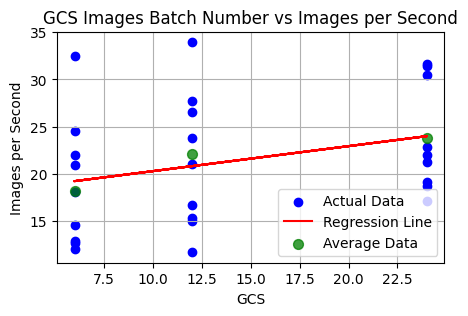

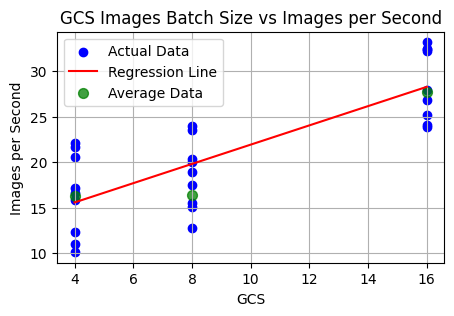

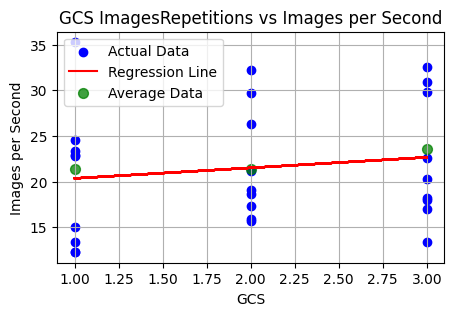

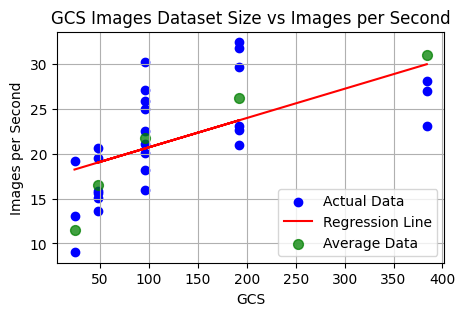

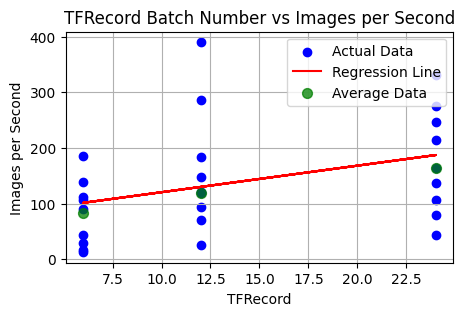

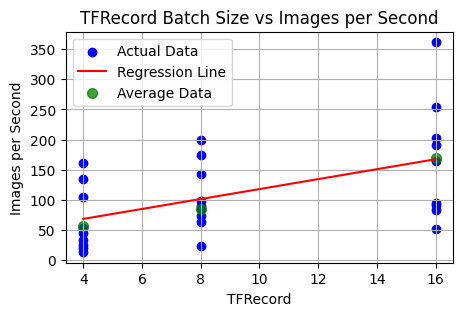

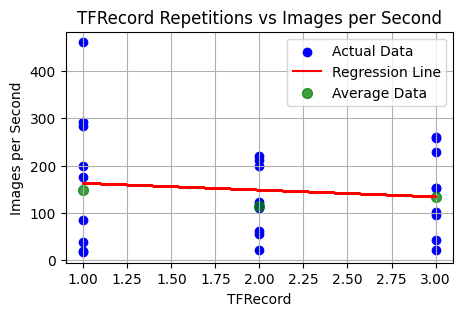

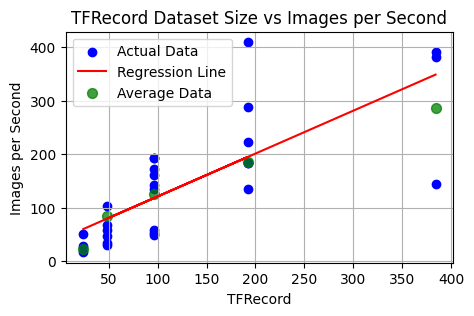

                 Parameter      Slope   Intercept  R_squared
0  GCS Images Batch Number   0.264556   17.651333   0.090515
1    GCS Images Batch Size   1.058500   11.333183   0.640897
2    GCS ImagesRepetitions   1.153492   19.206614   0.020340
3  GCS Images Dataset Size   0.032644   17.457259   0.333326
4    TFRecord Batch Number   4.763673   72.943610   0.136211
5      TFRecord Batch Size   8.246659   35.508046   0.263342
6     TFRecord Repetitions -14.322766  176.842934   0.012350
7    TFRecord Dataset Size   0.801398   40.695854   0.574986


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# function to do linear regresssion and plot the graphs
#
# params:
#
# df: dataframe to extract values to perform linear regression
# df_avg: dataframe to extract average values to plot the average values
# title: title for each linear regression graph
# x_label: label for the x axis
# y_label: label for the y axis
def perform_regression_and_plot(df, df_avg, title, x_label, y_label):
    X = df.iloc[:, 0].values.reshape(-1, 1) # get features from first column and assign to variable x
    y = df.iloc[:, 1].values # get target values from second column and assign to variable y
    model = LinearRegression().fit(X, y) # create the linear regression model
    predictions = model.predict(X) # make predictions

    # plot the linear regression graphs
    plt.figure(figsize=(5, 3))
    plt.scatter(X, y, color='blue', label='Actual Data')
    plt.plot(X, predictions, color='red', label='Regression Line')
    plt.scatter(df_avg.iloc[:, 0], df_avg.iloc[:, 1], color='green', s=50, alpha=0.75, label='Average Data')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

    # return table with the graph's slop, intercept, and r-squared
    return {'Slope': model.coef_[0], 'Intercept': model.intercept_, 'R_squared': model.score(X, y)}

# create list to append the tables
results_list = []

# parameters to perform linear regression on
parameters = [
    ("GCS Images Batch Number", df_batch_number_gcs, df_avg_batch_number_gcs),
    ("GCS Images Batch Size", df_batch_size_gcs, df_avg_batch_size_gcs),
    ("GCS ImagesRepetitions", df_rep_gcs, df_avg_rep_gcs),
    ("GCS Images Dataset Size", df_dataset_size_gcs, df_avg_dataset_size_gcs),
    ("TFRecord Batch Number", df_batch_number_tfrec, df_avg_batch_number_tfrec),
    ("TFRecord Batch Size", df_batch_size_tfrec, df_avg_batch_size_tfrec),
    ("TFRecord Repetitions", df_rep_tfrec, df_avg_rep_tfrec),
    ("TFRecord Dataset Size", df_dataset_size_tfrec, df_avg_dataset_size_tfrec)
]

# iterate through the parameters and apply the perform_regression_and_plot function
for param_name, df_param, df_avg_param in parameters:
    results = perform_regression_and_plot(df_param, df_avg_param, f"{param_name} vs Images per Second", param_name.split()[0], "Images per Second")
    results_list.append({
        "Parameter": param_name,
        "Slope": results['Slope'],
        "Intercept": results['Intercept'],
        "R_squared": results['R_squared']
    })

# convert results_list to dataframe
regression_results = pd.DataFrame(results_list)
# print the table
print(regression_results)




# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket

Removing gs://big-data-cw-420712-storage/install-python-packages.sh#1714125750437259...
Removing gs://big-data-cw-420712-storage/speed_test_results/speed_test_results2_240426-1508.pkl#1714144097489351...
Removing gs://big-data-cw-420712-storage/test#1714138620214886...
Removing gs://big-data-cw-420712-storage/speed_test_results/speed_test_results.pkl#1714072310405047...
Removing gs://big-data-cw-420712-storage/speed_test_results/speed_test_results2.pkl#1714080780797717...
Removing gs://big-data-cw-420712-storage/speed_test_results/speed_test_results2_240425-2305.pkl#1714086349525704...
Removing gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowers01-#1713539467357982...
Removing gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowers00-45.tfrec#1713805426549992...
Removing gs://big-data-cw-420712-storage/tfrecords-jpeg-192x192-2/flowers00-#1713539467261702...
Removing gs://big-data-cw-420712-storage/speed_test_results/speed_test_results2_240426-1614.pkl#171414804474